# Evolutionary Algorithms

This is the final project of the second block of the Evolutionary Algorithms subject of the Master in Software Engineering and Artificial Intelligence.

The project consists consists of solving an image reconstruction problem. 


## 1 - Problem

Given a black and white photograph represented as a matrix of size mxn where each position (i, j) is a value of 0-255 indicating the gray scale of the corresponding pixel. And given that they give us such a matrix but with the rows permuted in some unknown way. Our goal is to find a rearrangement of the rows so that we can reconstruct the original image. Obviously said rearrangement is represented by a permutation. Of course we do not know the original appearance of the photograph, since otherwise the problem would be trivial. We have to program an evolutionary algorithm to solve the problem.

One example of the imput images are:

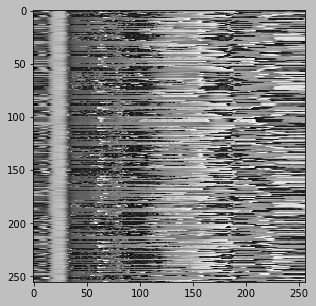

In [1]:
import time
import copy

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt 
from tabulate import tabulate

img0 = np.loadtxt('../data/img0-shuffled.txt')
plt.style.use('grayscale')
plt.figure(figsize=(15,5))
plt.imshow(img0)

## 2 - Steady State Genetic Algorithm (ssGA)

I alredy implemented the ssGA algorithm for the previous project and I will use the same implementation.

## 3 - Source Code

### 3.1 - Generic

In this section I will present my version of the ssGA. This version is adapted from the code written in Java found in the web of [neo](https://neo.lcc.uma.es/software/ssga/description.php) from the University of Malaga.

This section holds only the generic code applied to ssGA or event to every GA, the class specifications for the specific problem of the subset sum will be explained in the next section.

The first part of the code is the population. It is an abstraction to group a group of individuals. It takes as arguments the number of individuals and a function able to generate them. The population is generated at instantiation time.

This class has some additional functionalities like the possibility of iterating through it, access to random positions in its internal array, get the size of the population or print it.

In [2]:
class Population:
    def __init__(self, size, individual_generator):
        self._population = [individual_generator() for i in range(size)]
            
    def __getitem__(self, indices):
        return self._population[indices]
    
    def __setitem__(self, indices, values):
        raise NotImplemented
    
    def __iter__(self):
        self._n = 0
        return self

    def __next__(self):
        if self._n < len(self._population):
            self._n += 1
            return self._population[self._n-1]
        else:
            raise StopIteration
    
    def __str__(self):
        return '\n'.join([str(i) for i in self._population])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self._population)

Next we have the definition of a problem. This is an abstract class that will have to be specialized to a defined problem, it acts like the definitions of an interface mainly.

It says that with a problem we will be able to get the phenotype of an individual, get its fitness value and count the number of evaluations.

In [3]:
class Problem:
    def __init__(self):
        self.evaluations = 0
    
    def evaluate(self, indiv):
        self.evaluations += 1
        return self._evaluate(indiv)
        
    def _evaluate(self, indiv):
        raise NotImplemented       
        
    def phenotype(self, indiv):
        raise NotImplemented  

The same for the class EvolutionaryAlgorithm. It just define an interface that has to be implemented later on in a subclass.

In [4]:
class EvolutionaryAlgorithm:
    def __init__(self, problem, config):
        self.config = config
        self.problem = problem
        self.population = None
        self._generate_population()
        self.iterations = 0
        
    def _generate_population(self):
        raise NotImplemented
        
    def selection(self):
        raise NotImplemented
    
    def combination(self):
        raise NotImplemented
    
    def mutation(self):
        raise NotImplemented
        
    def replacement(self):
        raise NotImplemented
        
    def is_terminated(self):
        raise NotImplemented
        
    def step(self):
        self.iterations += 1
        self._step()
        
    def run(self):
        raise NotImplemented
    
    def get_solution(self):
        raise NotImplemented
        
    def _step(self):
        raise NotImplemented

The class Experiment in another interface. This one will be useful to hold different experiences to reach a conclusion. For example, it could hold different executions with different population sizes.

In [5]:
class Experiment:
    def __init__(self):
        self.config = None
        self.problem = None
        self.algorithm = None
        self.results = None
        
    def setup_execution(self):
        raise NotImplemented
    
    def teardown_execution(self):
        raise NotImplemented
    
    def execution(self):
        raise NotImplemented
    
    def run(self):
        raise NotImplemented

### 3.2 - Specific for the problem

In this section I will present the specialization of the previously explained interfaces and some other needed classes.

We are going to start choosing a representation for the individuals for this problem.

The chosen representation is an array of integers of the same length as the number of rows of the problem. 

I have kept the genotype and what we call the individual separated to keep the same structure than the original code.

The Chromosome is just an array of booleans randomly initialized and the Individual it is a class that holds a Chromosome and its fitness value.

In [6]:
class Chromosome:
    def __init__(self, length:int):
        self._alleles = np.array(range(length)).astype(np.int)
        np.random.shuffle(self._alleles)
    
    @staticmethod
    def from_values(values):
        c = Chromosome(len(values))
        c.alleles = values
        return c
    
    @property
    def alleles(self):
        return self._alleles
        
    @alleles.setter
    def alleles(self, values):
        self._alleles = np.array(list(values), dtype=np.int)
        
    def __getitem__(self, indices):
        return self.alleles[indices]
    
    def __setitem__(self, indices, values):
        self.alleles[indices] = values
    
    def __str__(self):
        return '-'.join([str(i) for i in self.alleles])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return self.alleles.size

In [7]:
class Individual:
    def __init__(self, length:int):
        self._chromosome = Chromosome(length)
        self._fitness = 0.0
    
    @staticmethod
    def get_factory(length):
        return lambda: Individual(length)
        
    @property
    def fitness(self):
        return self._fitness
        
    @fitness.setter
    def fitness(self, value:float):
        self._fitness = value
        
    @property
    def chromosome(self):
        return self._chromosome
        
    @chromosome.setter
    def chromosome(self, chrom):
        self._chromosome.alleles = Chromosome.from_values(chrom)
        
    def __eq__(self, other):
        return (self._chromosome.alleles == other.chromosome.alleles).all()
     
    def __lt__(self, other):
        return self.fitness < other.fitness
        
    def __le__(self, other):
        return self.fitness <= other.fitness
        
    def __gt__(self, other):
        return self.fitness > other.fitness
        
    def __ge__(self, other):
        return self.fitness >= other.fitness
        
    def __str__(self):
        return f'Chromosome: {self.chromosome}\nFitness: {self.fitness}'
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self.chromosome)

The specialization for the problem is defined in this class, ProblemSubsetSum. Here we define the fitness function as the square value of the difference of the sum of the phenotype of an individual and the target value.

In [8]:
class ProblemImage(Problem):
    def __init__(self, image):
        self._image = image
        super().__init__()
        
    def _evaluate(self, indiv):
        # return np.sum(np.abs(np.diff(self.phenotype(indiv), axis=0)))
        return np.sum(np.square(np.diff(self.phenotype(indiv), axis=0)))      
        
    def phenotype(self, indiv):
        return self._image[indiv.chromosome.alleles]
    
    def __str__(self):
        return f'Image:\n {self._image}'
    
    def __repr__(self):
        return self.__str__()

The specialization for EvolutionaryAlgorithm and Experiment are dependent of the experiment I run, so those will be explained in more detail in each experiment.

In this experiment I will vary the population size and we will study the effect in the found solutions and in the execution details.

The EvolutionaryAlgorithm specialization for this experiment is AlgoPopSize. Its characteristics in the different phases are:
- **Selection**: binary tournament.
- **Combination**: single point crossover.
- **Mutation**: random bit flip.
- **Replacement**: the worst individual is always replaced by the new one.
- **Termination**: after a maximum number of iterations or if the solution is found.

In [9]:
class AlgoImage(EvolutionaryAlgorithm):
    def __init__(self, problem, config):
        self._best_ever = None
        super().__init__(problem, config)
        self._aux = None
        self._last_best_fitness = float('INF')
        
    def _generate_population_new(self):
        self.population = Population(self.problem._image.shape[1], 
                                     Individual.get_factory(
                                         self.problem._image.shape[0])) 
            
        for i, indi in enumerate(self.population):
            rep = self.population[i]
            rep.chromosome = self.problem._image[:,i].argsort()
            indi.fitness = self.problem.evaluate(indi)
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))
        
    def _generate_population(self):
        self.population = Population(self.config['population_size'], 
                                     Individual.get_factory(
                                         self.problem._image.shape[0]))
        for i in self.population:
            i.fitness = self.problem.evaluate(i)
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))
        
    def selection(self):
        self._aux = (self._binary_tournament(), self._binary_tournament())
        return self._aux
    
    def combination(self):
        # no crossover
        if np.random.rand() > self.config['prob_crossover']:
            self._aux = np.random.choice(self._aux)
        else:
            self._aux = self._double_point_crossover(*self._aux)
        return self._aux
        
    def mutation(self):
        if np.random.rand() < self.config['prob_mutation']:
            i1 = np.random.randint(len(self._aux))
            i2 = i1
            while i1 == i2:
                i2 = np.random.randint(len(self._aux))
            self._aux.chromosome[i1], self._aux.chromosome[i2] = self._aux.chromosome[i2], self._aux.chromosome[i1]
        return self._aux
        
    def mutation2(self):
        if np.random.rand() < self.config['prob_mutation']:
            try:
                p = np.random.randint(len(self._aux))
                aux = np.array(self._aux.chromosome)
                self._aux.chromosome._alleles[:-p], self._aux.chromosome._alleles[-p:] = aux[p:], aux[:p]
            except Exception as e:
                print('mutation2 exception')
                print('self._aux', self._aux)
                print('aux', aux)
                print('exception', e)
        return self._aux
        
    def search(self):
        old_fit = self.problem.evaluate(self._aux)
        # one step search
        i1 = np.random.randint(len(self._aux))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self._aux))
        self._aux.chromosome[i1], self._aux.chromosome[i2] = self._aux.chromosome[i2], self._aux.chromosome[i1]
        self._aux.fitness = self.problem.evaluate(self._aux)
        # roll back if we dont improve
        if old_fit < self._aux.fitness:
            self._aux.chromosome[i1], self._aux.chromosome[i2] = self._aux.chromosome[i2], self._aux.chromosome[i1]
            self._aux.fitness = old_fit
        return self._aux
    
    def insert_solution(self):
        if np.random.rand() < self.config['prob_insert_solution']: 
            col = np.random.randint(self.problem._image.shape[1])
            print(f'Inserting solution sorting the column {col}')
            rep = max(self.population, key=lambda x: x.fitness)
            rep.chromosome = self.problem._image[:,col].argsort()
            rep.fitness = self.problem.evaluate(rep)
            self._aux = rep
            if rep.fitness < self._best_ever.fitness:
                self._best_ever = copy.deepcopy(rep)
        
    def replacement(self):
        rep = max(self.population, key=lambda x: x.fitness)
        rep.chromosome = self._aux.chromosome
        rep.fitness = self.problem.evaluate(rep)
        self._aux = rep
        if rep.fitness < self._best_ever.fitness:
            self._best_ever = copy.deepcopy(rep)
        return self._aux
    
    def regenerate(self):
        # save the 10% best solutions
        num_save = int(len(self.population)*0.1)
        bests = sorted(self.population)[:num_save]
        # regenerate the population randomly
        self._generate_population()
        # replace the worst 10%
        self.population._population = sorted(self.population)
        self.population._population[-num_save:] = bests
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))

    def is_terminated(self):
        if self.iterations >= self.config['max_num_iterations']:
            print(f'Terminated: Max number of iterations reached with {self.iterations}')
            return True
        return False
        
    def _step(self):
        self.selection()
        self.combination()
        self.mutation()
        self.mutation2()
        self.search()
        self.replacement()
        self.insert_solution()
        if self.iterations % 500 == 0:
            # if it doesnt improve at least 1% regenerate
            if abs(self._last_best_fitness - self._best_ever.fitness) < self._best_ever.fitness*0.01:
                print('regenerating the population')
                self.regenerate()
            self._last_best_fitness = self._best_ever.fitness
        
    def run(self):
        while not self.is_terminated():
            self.step()
        return self.get_solution()
    
    def get_solution(self):
        return self._best_ever
        
    def _binary_tournament(self):
        i1 = np.random.randint(len(self.population))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self.population))
        return min(self.population[i1], self.population[i2])
    
    def _single_point_crossover(self, p1, p2):
        point = np.random.randint(len(p1))
        result = copy.deepcopy(p1)
        # p would be a list of tuples with (number, index) sorted by index
        p = sorted([(i, np.where(p2.chromosome==i)[0].item()) for i in np.setdiff1d(p2.chromosome, p1.chromosome[:point])], key=lambda x: x[1])
        # now we insert them in order
        for index, (n, _) in enumerate(p):
            result.chromosome[point + index] = n 
        return result
    
    def _double_point_crossover(self, p1, p2):
        i1 = np.random.randint(len(p1))
        i2 = i1
        while i2 == i1:
            i2 = np.random.randint(len(p1))
        if i2 < i1:
            i1, i2 = i2, i1
        result = copy.deepcopy(p1)
        # p would be a list of tuples with (number, index) sorted by index
        p = sorted([(i, np.where(p2.chromosome==i)[0].item())
                    for i in np.setdiff1d(p2.chromosome, p1.chromosome[list(range(i1)) + list(range(i2,len(p1)))])],
                   key=lambda x: x[1])
        # now we insert them in order
        for index, (n, _) in enumerate(p):
            result.chromosome[i1 + index] = n 
        return result

The experiment is defined here. It holds a configuration for the problem with the specific parameters like probabilities of different events, execution parameters, etc.

It also holds the exact definition of the problem with the real numbers. The problem is generated randomly when we instantiate the experiment. I have defined the problem like a set with 200 integers between -100 and 100 and the target a number between -5000 and 5000. With this setup probabilistically I will get 100 positive numbers and 100 negative numbers, the average of the positive ones will be around 50, 50*100=5000, so I would have a good probability of getting a problem that is solvable. The same is valid for the negative numbers.

The other properties of the experiment are:
- Number of executions for every experience = 30
- Probability of crossover = 0.70
- Probability of mutation = 0.05

And the **populations size** we will try are **5, 10, 50, 100, 500, 1000** individuals.

In [15]:
import tqdm

class ExpImg0(Experiment):
    def __init__(self):
        super().__init__()
        # specific definition of the problem
        img0 = np.loadtxt('../data/img1-shuffled.txt')
        # configuration of the experiment
        self.config = {
            # config for the experiment
            'number_executions': 1,
            'change_rand_seed': False,
            # config for the algo
            'algorithm': AlgoImage,
            'population_size': 100,
            'prob_crossover': 0.8,
            'prob_mutation': 0.05,
            'prob_insert_solution': 0.001,
            'max_num_iterations': 100000,
            # config of the problem
            'problem': ProblemImage,
            'problem_args': (img0,)
        }
        # save things to plot later
        self.results = []
        self._results_execution = []
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
        self._time = None
        self._time_execution = None
        self._time_step = None
        # the seed used 
        self.random_seed = 0
        
    def setup_execution(self):
        # setup random seed
        if self.config['change_rand_seed']:
            np.random.seed(self.random_seed)
            self.random_seed += 1
        # create new problem and population
        self.problem = self.config['problem'](*self.config['problem_args'])
        self.algorithm = self.config['algorithm'](self.problem, self.config)
    
    def teardown_execution(self):
#        solution = self.problem.phenotype(self.algorithm.get_solution())
#        print('solution', solution)
#        print('sum(solution): ', sum(solution))
#        print('self.problem.evaluations: ', self.problem.evaluations)
#        print('--------------------------------------------------')
        pass
    
    def execution(self):
        # while not self.algorithm.is_terminated():
        started = time.time()
        for i in tqdm.tqdm(range(self.config['max_num_iterations'])):
            self._time_step = time.time()
            self.algorithm.step()
            self._time_step = time.time() - self._time_step
            self._save_results_step()
            if i % 200 == 0:
                print('-----------------------------------------------')
                print(f'iteration: {i}')
                print(f'time: {time.time()-started}')
                sol = self.algorithm.get_solution()
                print(f'best fitness: {sol.fitness}')
                plt.imshow(self.problem.phenotype(sol))
                plt.show()
        
    def run(self):
        self._time = time.time()
        for i in range(self.config['number_executions']):
            self.setup_execution()
            # self._time_execution = time.time()
            self.execution()
            # self._time_execution = time.time() - self._time_execution
            self.teardown_execution()
            self._save_results_execution()
                
        self._time = time.time() - self._time
        #print(f'Took {self._time} seconds.')
        self._save_results_experiment()
            
    def get_problem(self):
        return self.config['problem'](*self.config['problem_args'])
    
    def _save_results_step(self):
        best = min(self.algorithm.population, key=lambda x: x.fitness)
        worst = max(self.algorithm.population, key=lambda x: x.fitness)
        best_ever = self.algorithm.get_solution()
        average_fitness = sum([i.fitness for i in self.algorithm.population])/len(self.algorithm.population)
        iteration = self.algorithm.iterations
        self._results_step['best'].append(copy.deepcopy(best))
        self._results_step['worst'].append(copy.deepcopy(worst))
        self._results_step['best_ever'].append(copy.deepcopy(best_ever))
        self._results_step['average_fitness'].append(average_fitness)
        self._results_step['iteration'].append(iteration)
        self._results_step['time'].append(self._time_step)
    
    def _save_results_execution(self):
        self._results_execution.append(copy.deepcopy(self._results_step))
        # to hold the results within the execution
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
    
    def _save_results_experiment(self):
        self.results.append(copy.deepcopy(self._results_execution))
        self._results_execution = []

The experiment takes time to run so we want to save the results to use them later on, then if we turn off the computer or restart the kernel we can deserialize the results and continue from here.

  0%|          | 0/100000 [00:00<?, ?it/s]

-----------------------------------------------
iteration: 0
time: 0.3635842800140381
best fitness: 299423704.0


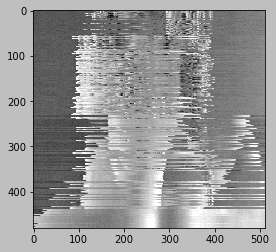

  0%|          | 200/100000 [00:28<5:47:52,  4.78it/s]

-----------------------------------------------
iteration: 200
time: 28.879721641540527
best fitness: 247684256.0


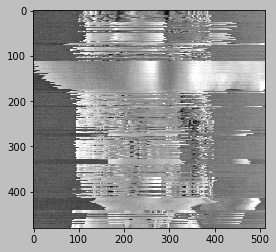

  0%|          | 397/100000 [00:55<3:30:39,  7.88it/s]

-----------------------------------------------
iteration: 400
time: 56.14645004272461
best fitness: 231582153.0


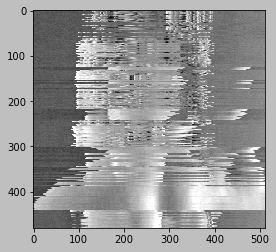

  1%|          | 599/100000 [01:30<8:01:41,  3.44it/s]

-----------------------------------------------
iteration: 600
time: 90.20516157150269
best fitness: 231582153.0


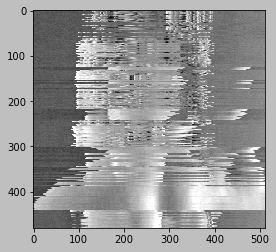

  1%|          | 800/100000 [02:04<3:16:35,  8.41it/s]

-----------------------------------------------
iteration: 800
time: 125.41831469535828
best fitness: 210752685.0


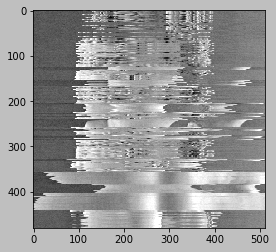

  1%|          | 998/100000 [02:34<4:33:48,  6.03it/s]

-----------------------------------------------
iteration: 1000
time: 154.90235948562622
best fitness: 210752685.0


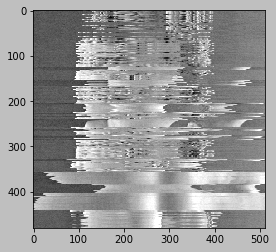

  1%|          | 1200/100000 [03:06<4:22:12,  6.28it/s]

-----------------------------------------------
iteration: 1200
time: 187.11771249771118
best fitness: 200727495.0


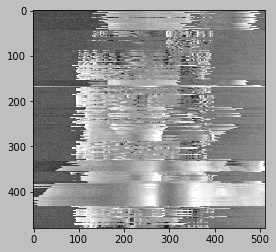

  1%|▏         | 1398/100000 [03:36<4:58:04,  5.51it/s]

-----------------------------------------------
iteration: 1400
time: 216.68654656410217
best fitness: 192511410.0


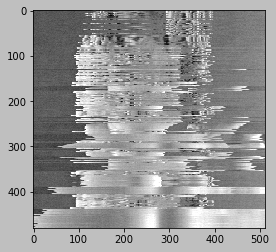

  2%|▏         | 1599/100000 [04:07<4:04:29,  6.71it/s]

-----------------------------------------------
iteration: 1600
time: 247.93574619293213
best fitness: 176111059.0


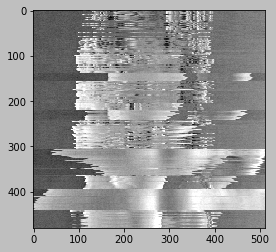

  2%|▏         | 1800/100000 [04:38<5:14:16,  5.21it/s]

-----------------------------------------------
iteration: 1800
time: 279.1239879131317
best fitness: 176111059.0


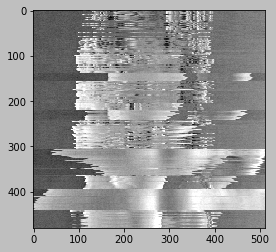

  2%|▏         | 2000/100000 [05:08<4:44:38,  5.74it/s]

-----------------------------------------------
iteration: 2000
time: 308.37296175956726
best fitness: 171034139.0


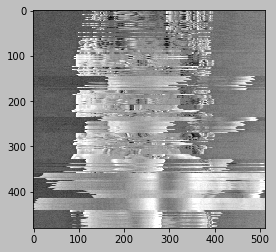

  2%|▏         | 2199/100000 [05:36<3:15:22,  8.34it/s]

-----------------------------------------------
iteration: 2200
time: 336.1270809173584
best fitness: 169001505.0


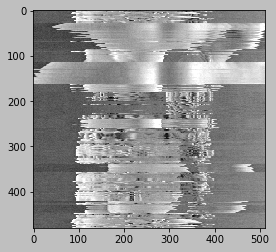

  2%|▏         | 2301/100000 [05:49<2:54:39,  9.32it/s]

Inserting solution sorting the column 409


  2%|▏         | 2312/100000 [05:50<3:09:12,  8.60it/s]

Inserting solution sorting the column 464


  2%|▏         | 2400/100000 [06:04<4:23:31,  6.17it/s]

-----------------------------------------------
iteration: 2400
time: 364.5552134513855
best fitness: 169001505.0


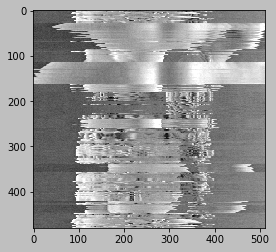

  3%|▎         | 2554/100000 [06:27<4:06:25,  6.59it/s]


KeyboardInterrupt: 

In [16]:
%%time
%%prun
import os
import pickle

f_name = '../data/experiment_img0.pckl'

force_run = True

if not force_run and os.path.exists(f_name):
    # load the results
    with open(f_name, 'rb') as f:
        experiment_img0 = pickle.load(f)
else:
    # run the experiment
    experiment_img0 = ExpImg0()
    experiment_img0.run()
    # save results
    with open(f_name, 'wb') as f:
        pickle.dump(experiment_img0, f)

        
results = experiment_img0.results
config = experiment_img0.config
problem = experiment_img0.get_problem()

In [12]:
asdafdsfasa
p = Population(10, Individual.get_factory(5))
for i, indi in enumerate(p):
    indi.fitness = i
print(p)

a = sorted(p)[:5]
print(a)

p = Population(10, Individual.get_factory(5))
for i, indi in enumerate(p):
    indi.fitness = i
p._population = sorted(p)

p._population[-5:] = a
print(p)

NameError: name 'asdafdsfasa' is not defined

In [ ]:
%%time
%%prun
import os
import pickle

f_name = '../data/experiment_img0.pckl'


# run the experiment
experiment_img0.config['max_num_iterations'] = 10000
experiment_img0.execution()
# save results
with open(f_name, 'wb') as f:
    pickle.dump(experiment_img0, f)

        
results = experiment_img0.results
config = experiment_img0.config
problem = experiment_img0.get_problem()

From this point the results are in the variable *results* and this is what we are going to use to do the plots.

In [ ]:
len(experiment_img0.results[0][0]['best_ever'])

In [ ]:
results = experiment_img0.results
config = experiment_img0.config
problem = experiment_img0.get_problem()

In [ ]:
plt.imshow(problem.phenotype(experiment_img0.results[0][0]['best_ever'][-1]))

In [ ]:
for exe in results[0]:
    fitness = [b.fitness for b in exe['best']]
    _ax, = plt.plot(fitness)
plt.show() 

In [ ]:
plt.imshow(problem.phenotype(experiment_img0.results[0][0]['best_ever'][-1]))

In [ ]:
!pip3 install tqdm